In [6]:
# ==========================================
# MoNuSeg - Watershed Segmentation
# With vs Without Marker Control
# ==========================================

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from scipy import ndimage as ndi

# ===== UPDATE PATHS =====
image_dir = r"C:\Users\tripa\OneDrive\Desktop\IIITR B.TECH\SEM-06\MIP\Assignment 02\MoNuSeg 2018 Training Data\MoNuSeg 2018 Training Data\Tissue Images"
annotation_dir = r"C:\Users\tripa\OneDrive\Desktop\IIITR B.TECH\SEM-06\MIP\Assignment 02\MoNuSeg 2018 Training Data\MoNuSeg 2018 Training Data\Annotations"
# ========================

image_files = sorted(os.listdir(image_dir))
annotation_files = sorted(os.listdir(annotation_dir))

print("Image files:", image_files[:5])
print("Annotation files:", annotation_files[:5])

# Check what extensions are available
ext_found = set([os.path.splitext(f)[1] for f in annotation_files])
print("Annotation file extensions:", ext_found)

Image files: ['TCGA-18-5592-01Z-00-DX1.tif', 'TCGA-21-5784-01Z-00-DX1.tif', 'TCGA-21-5786-01Z-00-DX1.tif', 'TCGA-38-6178-01Z-00-DX1.tif', 'TCGA-49-4488-01Z-00-DX1.tif']
Annotation files: ['TCGA-18-5592-01Z-00-DX1.xml', 'TCGA-21-5784-01Z-00-DX1.xml', 'TCGA-21-5786-01Z-00-DX1.xml', 'TCGA-38-6178-01Z-00-DX1.xml', 'TCGA-49-4488-01Z-00-DX1.xml']
Annotation file extensions: {'.xml'}


In [7]:
# -------- Convert XML to Binary Mask --------
def xml_to_mask(xml_path, shape):
    mask = np.zeros(shape, dtype=np.uint8)
    tree = ET.parse(xml_path)
    root = tree.getroot()

    for region in root.iter('Region'):
        points = []
        for vertex in region.iter('Vertex'):
            x = int(float(vertex.attrib['X']))
            y = int(float(vertex.attrib['Y']))
            points.append([x, y])
        points = np.array(points)
        cv2.fillPoly(mask, [points], 1)

    return mask

# -------- Dice Score --------
def dice_score(pred, gt):
    intersection = np.sum(pred * gt)
    return (2. * intersection) / (np.sum(pred) + np.sum(gt) + 1e-7)

# Initialize lists to store results
dice_no_marker = []
dice_marker = []

In [8]:
# ========================================
# Main Processing Loop
# Process each image with both methods
# ========================================

for img_name in image_files[:10]:  # limit to 10 for faster testing

    img_path = os.path.join(image_dir, img_name)
    # Replace .tif with .xml for annotation file
    xml_name = os.path.splitext(img_name)[0] + ".xml"
    xml_path = os.path.join(annotation_dir, xml_name)

    image = cv2.imread(img_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    # Convert XML annotation to mask
    gt_mask = xml_to_mask(xml_path, gray.shape)

    # -------- Basic Threshold --------
    _, thresh = cv2.threshold(gray, 0, 255,
                              cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    thresh = cv2.bitwise_not(thresh)

    # =====================================
    # 1. WITHOUT MARKER CONTROL
    # =====================================
    dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, 0.4 * dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1

    markers_no = cv2.watershed(image_rgb, markers.copy())
    seg_no = (markers_no > 1).astype(np.uint8)

    # =====================================
    # 2️. MARKER-CONTROLLED WATERSHED
    # =====================================
    kernel = np.ones((3,3), np.uint8)
    opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

    sure_bg = cv2.dilate(opening, kernel, iterations=3)

    dist = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
    _, sure_fg = cv2.threshold(dist, 0.5 * dist.max(), 255, 0)
    sure_fg = np.uint8(sure_fg)

    unknown = cv2.subtract(sure_bg, sure_fg)

    ret, markers = cv2.connectedComponents(sure_fg)
    markers = markers + 1
    markers[unknown == 255] = 0

    markers_ctrl = cv2.watershed(image_rgb, markers)
    seg_ctrl = (markers_ctrl > 1).astype(np.uint8)

    # ---- Dice Evaluation ----
    dice_no_marker.append(dice_score(seg_no, gt_mask))
    dice_marker.append(dice_score(seg_ctrl, gt_mask))

Average Dice WITHOUT markers: 0.15838889684029775
Average Dice WITH markers: 0.45576908294583307


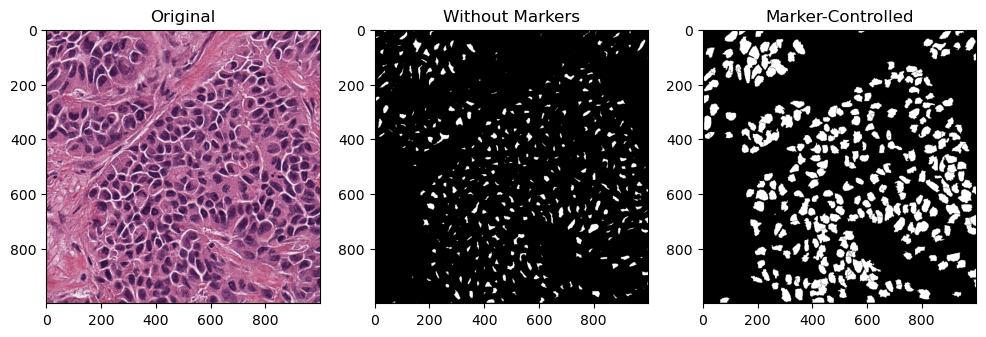

In [9]:
# ===== Final Results and Visualization =====
print("Average Dice WITHOUT markers:", np.mean(dice_no_marker))
print("Average Dice WITH markers:", np.mean(dice_marker))

# ===== Show Example =====
plt.figure(figsize=(12,6))
plt.subplot(1,3,1)
plt.imshow(image_rgb)
plt.title("Original")

plt.subplot(1,3,2)
plt.imshow(seg_no, cmap='gray')
plt.title("Without Markers")

plt.subplot(1,3,3)
plt.imshow(seg_ctrl, cmap='gray')
plt.title("Marker-Controlled")

plt.show()